# nvImageCodec transcode examples

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from nvidia import nvimgcodec

Setting resource folder and creation of nvImageCodec decoder and encoder

In [2]:
resources_dir = os.getenv("PYNVIMGCODEC_EXAMPLES_RESOURCES_DIR", "../assets/images/")

decoder = nvimgcodec.Decoder()
encoder = nvimgcodec.Encoder()

### Lossless uint8

codec: png    ; data type: uint8; is image equal after transcoding: True
codec: bmp    ; data type: uint8; is image equal after transcoding: True
codec: jpeg2k ; data type: uint8; is image equal after transcoding: True
codec: pnm    ; data type: uint8; is image equal after transcoding: True
codec: tiff   ; data type: uint8; is image equal after transcoding: True
codec: webp   ; data type: uint8; is image equal after transcoding: True


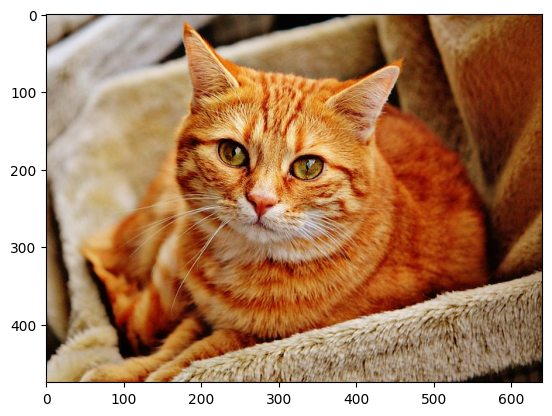

In [3]:
example_image = np.asarray(decoder.read(resources_dir + "cat-1046544_640.jp2").cpu())
plt.imshow(example_image)

for extension in ["png", "bmp", "jpeg2k", "pnm", "tiff", "webp"]:
    if extension == "jpeg2k":
        encode_params = nvimgcodec.EncodeParams(jpeg2k_encode_params=nvimgcodec.Jpeg2kEncodeParams(reversible=True))
    elif extension == "webp":
        encode_params = nvimgcodec.EncodeParams(quality=101) # Any value greater than 100 means lossless for WebP
    else:
        encode_params = None # Other codecs use lossless compression by default
    
    encoded = encoder.encode(example_image, extension, encode_params)
    decoded = np.asarray(decoder.decode(encoded).cpu())

    print(f"codec: {extension.ljust(7)}; data type: {decoded.dtype}; is image equal after transcoding:", (decoded == example_image).all())

### Lossless uint16

In [4]:
example_image = example_image.astype(np.uint16) * 255 # Convert to uint16

for extension in ["png", "jpeg2k", "pnm", "tiff"]:
    if extension == "jpeg2k":
        encode_params = nvimgcodec.EncodeParams(jpeg2k_encode_params=nvimgcodec.Jpeg2kEncodeParams(reversible=True))
    elif extension == "webp":
        encode_params = nvimgcodec.EncodeParams(quality=101) # Any value greater than 100 means lossless for WebP
    else:
        encode_params = None # Other codecs use lossless compression by default
    
    encoded = encoder.encode(example_image, extension, encode_params)

    # DecodeParams are required to decode into uint16 instead of uint8
    decode_params = nvimgcodec.DecodeParams(allow_any_depth=True)
    decoded = np.asarray(decoder.decode(encoded, decode_params).cpu())

    print(f"codec: {extension.ljust(6)} ; data type: {decoded.dtype}; is image equal after transcoding:", (decoded == example_image).all())

codec: png    ; data type: uint16; is image equal after transcoding: True
codec: jpeg2k ; data type: uint16; is image equal after transcoding: True
codec: pnm    ; data type: uint16; is image equal after transcoding: True
codec: tiff   ; data type: uint16; is image equal after transcoding: True


### Lossy uint8
Quality values used are low, so that the difference between original and transcoded images is easy to spot.


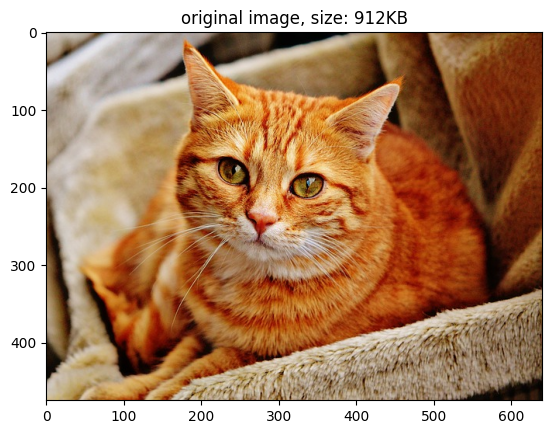

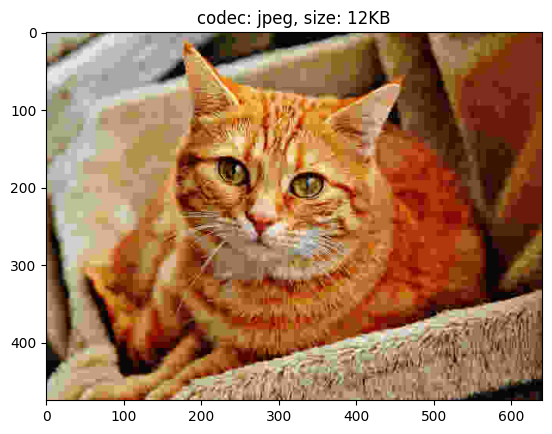

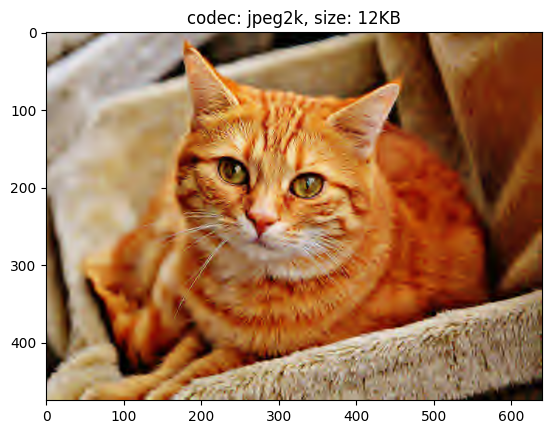

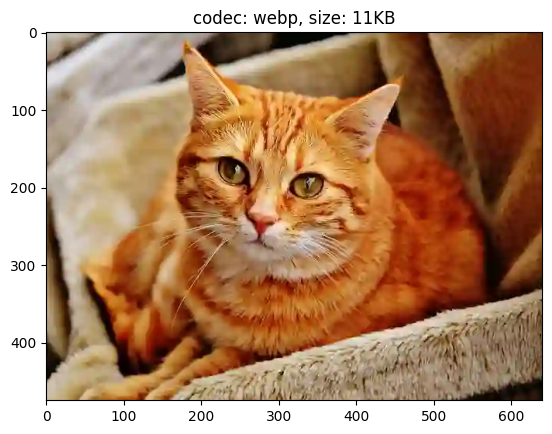

In [5]:
example_image = np.asarray(decoder.read(resources_dir + "cat-1046544_640.jp2").cpu())
plt.title(f"original image, size: {example_image.size // 1000}KB")
plt.imshow(example_image)
plt.show()

for extension in ["jpeg", "jpeg2k", "webp"]:
    if extension == "jpeg2k":
        # if Jpeg2kEncodeParams are ommited, reversible=False is assumed and target_psnr controls quality
        encode_params = nvimgcodec.EncodeParams(target_psnr=27)
    else:
        # Other codecs use quality
        encode_params = nvimgcodec.EncodeParams(quality=5)
    
    encoded = encoder.encode(example_image, extension, encode_params)
    decoded = np.asarray(decoder.decode(encoded).cpu())
    plt.title(f"codec: {extension}, size: {len(encoded) // 1000}KB")
    plt.imshow(decoded)
    plt.show()